# General tests of te AIS

Created on Tue Nov 22 16h24m,  2022

This is a script for the development of general tests

@author: denis


In [ ]:
# Test the sbpy package
from sbpy.calib import Vega, vega_fluxd

print(vega_fluxd.get()["Johnson V"])

In [ ]:
# Test the PSF class
from AIS.Point_Spread_Function import Point_Spread_Function
import matplotlib.pyplot as plt

ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}
psf = Point_Spread_Function(ccd_operation_mode, 1)
image = psf.create_star_image((50, 50), 1e3, 1e3)
plt.imshow(image)
plt.show()

In [ ]:
# Test the AIS.create_image function
from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import os

ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}

wavelength_interval = (400, 1100, 100)
ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)
ais.create_source_sed("blackbody", 15, wavelength_interval, 5700)
ais.create_sky_sed("new")
ais.apply_atmosphere_spectral_response(air_mass=1.2, sky_condition="photometric")
ais.apply_telescope_spectral_response()
ais.apply_sparc4_spectral_response("photometry")
ais.create_artificial_image(os.path.join("E:", "images", "test"))

In [ ]:
# Create a time series of images

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from sys import exit
from time import sleep
import os

ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}

n = 100
images_path = os.path.join("E:", "images", "test")
time = np.linspace(0, 2 * pi, n)
mags = 15 + 0.1 * np.sin(time) + np.random.normal(0, 0.01, n)

ais = Artificial_Image_Simulator(ccd_operation_mode, channel_id=1, ccd_temperature=-70)
ais.create_bias_image(images_path, 10)
ais.create_flat_image(images_path, 20)


for mag in mags:
    ais = Artificial_Image_Simulator(
        ccd_operation_mode, channel_id=1, ccd_temperature=-70
    )
    ais.create_source_sed(
        calculation_method="blackbody",
        magnitude=mag,
        wavelength_interval=(400, 1100, 1000),
        temperature=5700,
    )
    ais.create_sky_sed(moon_phase="new")
    ais.apply_atmosphere_spectral_response()
    ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response(acquisition_mode="photometry")
    ais.create_artificial_image(image_path=images_path, star_coordinates=(50, 50))
    sleep(ccd_operation_mode["t_exp"])

In [ ]:
# Create video polarimetry

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}
path = r"E:\images\test"

ais = Artificial_Image_Simulator(ccd_operation_mode, channel_id=1, ccd_temperature=-70)

for i in range(286, 360):
    print(i)
    ais.create_source_sed(
        calculation_method="blackbody",
        magnitude=12,
        wavelength_interval=(400, 1100, 1000),
        temperature=5700,
    )
    ais.create_sky_sed(moon_phase="new")
    ais.apply_atmosphere_spectral_response()
    ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response("polarimetry", "polarizer", "half", i)
    image = ais.create_artificial_image(image_path=path, star_coordinates=(50, 50))
    median = np.median(image)
    std = np.std(image)
    file = os.path.join(path, f"ret_angle_{i:03}.png")
    ann = plt.annotate(
        f"waveplate angle: {i} deg",
        (0.9, 0.9),
        xycoords="axes fraction",
        ha="right",
        color="white",
    )
    plt.imshow(
        image[0], cmap="gray", origin="lower", vmin=median - 3 * std, vmax=2 * median
    )
    plt.savefig(file)
    ann.remove()

# ---------------------------------------------------------------------------------------------------

# Create GIF
import os
import cv2
import glob
import imageio
from sys import exit
import matplotlib.pyplot as plt

path = r"E:\images\test"
files = os.listdir(path)
frameSize = (640, 480)

out = cv2.VideoWriter(
    path + "\\" + "output_video.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 15, frameSize
)


for filename in glob.glob(path + "\\*.png"):
    img = cv2.imread(filename)
    out.write(img)

out.release()

In [ ]:
# Create gaussian with noise
from AIS.Point_Spread_Function import Point_Spread_Function
import matplotlib.pyplot as plt
import os

ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 50,
}
psf = Point_Spread_Function(ccd_operation_mode, 1)
image = psf.create_star_image((25, 25), 1e3)
plt.imshow(image, cmap="gray")
plt.savefig(os.path.join("notebook", "figures", "gaussiana_com_ruido.png"), dpi=300)

-32878.57142857143 45656261.9047619


Text(0, 0.5, 'Phase shift (deg)')

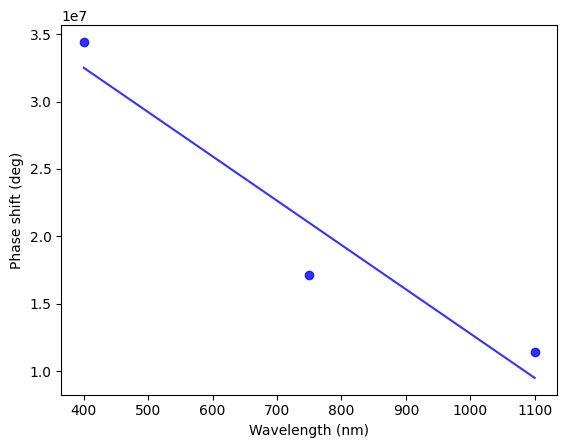

In [26]:
# DEPOLARIZER: PHASE SHIFT LINEAR ADJUSTMENT
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

base_path = os.path.join("AIS", "Spectral_Response", "channel")
file = "depolarizer_shifts.txt"

dict = {"wavelength": [], "shift": []}
with open(os.path.join(base_path, file), "r") as file:
    text = file.readlines()

for line in text[1:4]:
    line = line.split(",")
    dict["wavelength"].append(float(line[0]))
    dict["shift"].append(float(line[2]))

x, y = np.asarray(dict["wavelength"]), dict["shift"]
slope, intercept, *_ = linregress(x, y)
adjust = lambda x: slope * x + intercept
print(slope, intercept)

plt.plot(x, y, "bo", alpha=0.8)
plt.plot(x, adjust(x), "b-", alpha=0.8)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Phase shift (deg)")